In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns

In [6]:
def min_max_normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [7]:
#General visualization settings
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks

plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)

In [8]:
#Path settings
root_path = Path(r"C:\Users\neurogears\OneDrive - NeuroGEARS Ltd\CricketPrelemdata\ScreenBenchmarking")
#session_id = "05_06_2022_15_20_18"
session_id = "05_10_2022_18_20_22"
session_path = root_path / session_id


#### Benchmarking round trip delays
- Experiment triggered a quad on the screen, which was measure by a photodiode (1kHz). Once a value past a threshold was measured, the quad was toggled.
- The file saved the harp time between toggles (1 -> 0 and 0 ->1 )

Text(0.5, 0.98, 'Round trip latency')

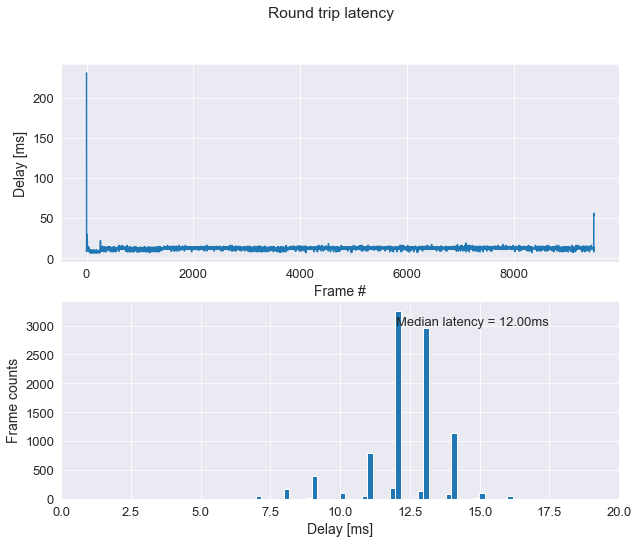

In [9]:
# Load the latency data between two frames
round_trip_latency = pd.read_csv(session_path / "ClosedLoopScreenLag.csv")['Seconds'].values[:]
round_trip_latency = round_trip_latency * 1e3

f = plt.figure(figsize = (10,8))
ax = f.add_subplot((211))
ax.plot(round_trip_latency)
ax.set_xlabel("Frame #")
ax.set_ylabel("Delay [ms]")

ax2 = f.add_subplot(212)
w = 0.0002 * 1e3
ax2.hist(round_trip_latency, bins=np.arange(min(round_trip_latency), max(round_trip_latency) + w, w))
ax2.set_xlim((0*1e3, 0.02*1e3))
ax2.set_ylabel("Frame counts")
ax2.set_xlabel("Delay [ms]")
ax2.text(12, 3000, "Median latency = {0:.2f}ms".format(np.median(round_trip_latency)))

f.suptitle("Round trip latency")



#### Benchmarking mouse movement -> Screen change latency
- Mouse movement is recorded with a camera (side view measuring overall motion energy)
- Same camera is recording the scree
- Screen is rendering a checkboard texture which xy phase is driven by the mouse position.
- Checking when the mouse moves in the camera and when the checkboard moves in the camera will give us the latency an approximate mouse -> render

['BallEnergy', 'ScreenEnergy', 'HarpTimestamp', 'FrameID',
       'CameraTimestamp']

0 frames were lost!
Frame rate estimated to be 200.02 fps


Text(0.5, 1.0, 'ScreenEnergy')

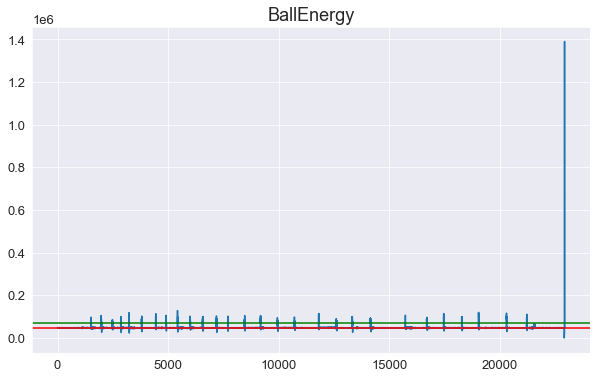

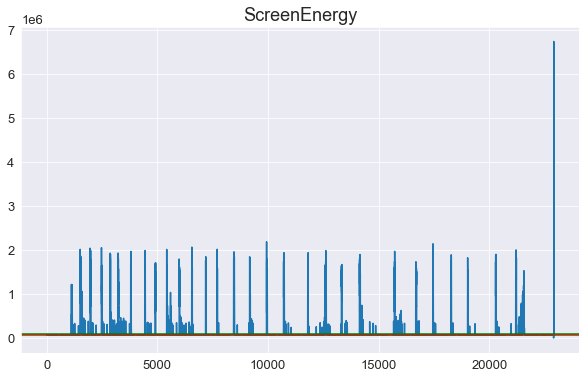

In [136]:
#Load camera data
energy_metadata = pd.read_csv(session_path / "computerVision.csv")

stdGain = 2
#Sanity check for dropped frames
lost_frames = np.diff(energy_metadata["FrameID"].values) - 1
print("{0} frames were lost!".format(np.sum(lost_frames)))
#Check the fps
diff_t_frames = np.diff(energy_metadata["CameraTimestamp"])
print("Frame rate estimated to be {0:0.2f} fps".format(1.0 / (1e-9 * np.median(diff_t_frames))))

fig = plt.figure(figsize=(10,6))
plt.plot(energy_metadata["BallEnergy"])
plt.axhline(np.median(energy_metadata["BallEnergy"]), c = 'red')
plt.axhline(np.median(energy_metadata["BallEnergy"]) + np.std(energy_metadata["BallEnergy"]) * stdGain, c = 'green')
plt.title("BallEnergy")

fig = plt.figure(figsize=(10,6))
plt.plot(energy_metadata["ScreenEnergy"])
plt.axhline(np.median(energy_metadata["ScreenEnergy"]), c = 'red')
plt.axhline(np.median(energy_metadata["ScreenEnergy"]) + np.std(energy_metadata["BallEnergy"]) * stdGain, c = 'green')
plt.title("ScreenEnergy")


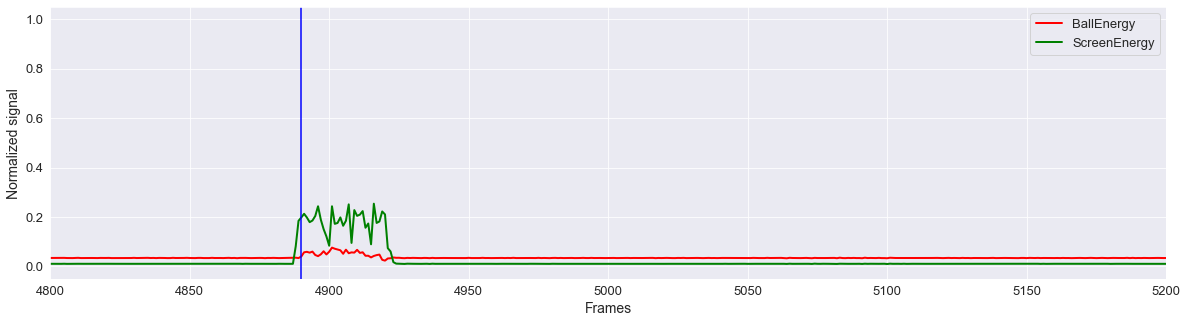

In [149]:
# Automatic detection of mouse movement
magnitude_threshold = np.median(energy_metadata["BallEnergy"]) + 1 * np.std(energy_metadata["BallEnergy"])
# 1 * std is a relatively high threshold, the onset will likely be delayed from 0.
# That said, we can always plot both signals at the end to get a more precise alignment
throttle_threshold = 1 # refractory period of event detection (in seconds)
fps = 200 # Hz
half_win_size_frames = int((throttle_threshold * fps)/2)

#Find initial crossings & binarize
candidate_crossings = energy_metadata["BallEnergy"] > magnitude_threshold # binarize
candidate_crossings = pd.Series(candidate_crossings).rolling(half_win_size_frames * 2).max().values #maximum filter


# correct the kernel shift (does not seem to be needed???, the kernel is not centered)
#candidate_crossings = np.concatenate((np.zeros((half_win_size_frames,)), candidate_crossings[0:-half_win_size_frames]))

candidate_crossings = np.where(np.diff(candidate_crossings.astype(float)) == 1)[0] # find onsets and correct for derivative

plt.figure(figsize=(20,5))
plt.plot(min_max_normalize(energy_metadata["BallEnergy"]), c='red', lw = 2, label = "BallEnergy")
plt.plot(min_max_normalize(energy_metadata["ScreenEnergy"]), c='green', lw = 2, label = "ScreenEnergy")
plt.legend()
[plt.axvline(trig, c='blue') for trig in candidate_crossings]
plt.xlabel("Frames")
plt.ylabel("Normalized signal")
plt.xlim((4800, 5200))
plt.show()

Text(0.5, 1.0, 'ScreenEnergy')

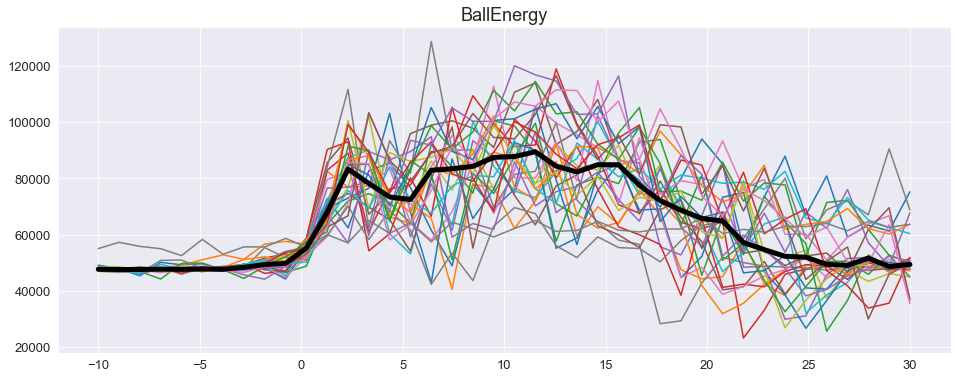

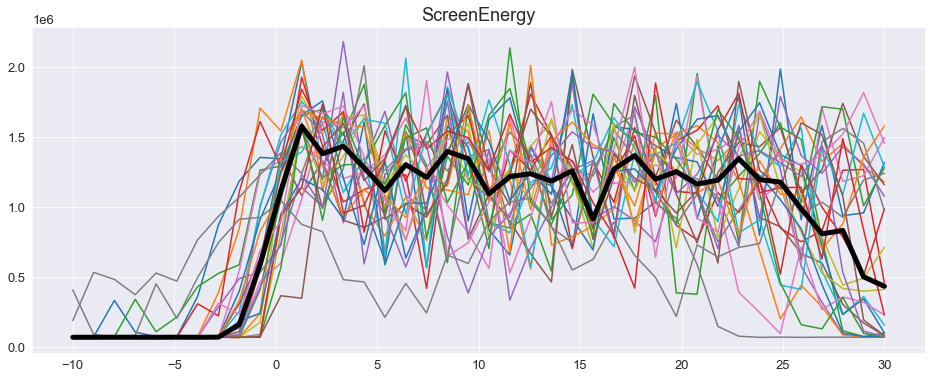

In [157]:
win_frames_2plot = (-10, 30)
ts = np.linspace(win_frames_2plot[0],win_frames_2plot[1], np.diff(win_frames_2plot)[0])

fig = plt.figure(figsize=(16,6))
[plt.plot(ts, energy_metadata["BallEnergy"][x + win_frames_2plot[0]: x + win_frames_2plot[1]])  for x in candidate_crossings[1:-1]]

plt.plot(ts,
         np.median(np.vstack([(energy_metadata["BallEnergy"][x + win_frames_2plot[0]: x + win_frames_2plot[1]])  for x in candidate_crossings[1:-1]]), axis = 0),
         c = "black", lw = 5)
plt.title("BallEnergy")
plt.xlabel("Time(Frames)")
plt.ylabel("Energy(a.u.)")


fig = plt.figure(figsize=(16,6))
[plt.plot(ts, energy_metadata["ScreenEnergy"][x + win_frames_2plot[0]: x + win_frames_2plot[1]])  for x in candidate_crossings[1:-1]]
plt.plot(ts,
         np.median(np.vstack([(energy_metadata["ScreenEnergy"][x + win_frames_2plot[0]: x + win_frames_2plot[1]])  for x in candidate_crossings[1:-1]]), axis = 0),
         c = "black", lw = 5)
plt.title("ScreenEnergy")
plt.xlabel("Time(Frames)")
plt.ylabel("Energy(a.u.)")



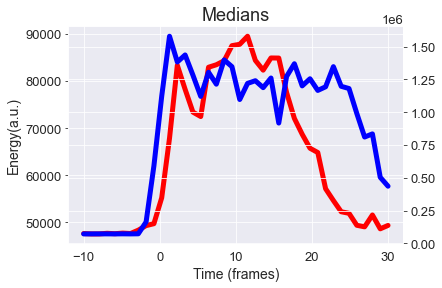

In [160]:
fig, ax1 = plt.subplots()

ax1.plot(ts,
         np.median(np.vstack([(energy_metadata["BallEnergy"][x + win_frames_2plot[0]: x + win_frames_2plot[1]])  for x in candidate_crossings[1:-1]]), axis = 0),
         c = "red", lw = 5, label = "BallEnergy")

ax2 = ax1.twinx()
ax2.plot(ts,
         np.median(np.vstack([(energy_metadata["ScreenEnergy"][x + win_frames_2plot[0]: x + win_frames_2plot[1]])  for x in candidate_crossings[1:-1]]), axis = 0),
         c = "blue", lw = 5, label = "ScreenEnergy")
plt.title("Medians")
ax1.set_xlabel("Time (frames)")
ax1.set_ylabel("Energy(a.u.)")

plt.show()
